In [1]:
#this notebook is to test training on CIFAR10 dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# hyper-parameter
num_epochs = 8
batch_size = 50
learning_rate = 0.001

In [4]:
# tramform data to tensor of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# load CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers = 2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers = 2)

In [6]:
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show img
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

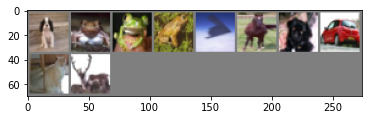

In [15]:
# check random img from trainset
dataiter = iter(trainloader)
images, labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))

In [7]:
#define network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
#create model and move to GPU
model = ConvNet().to(device)

#define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
#train the model
n_total_steps = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        #move to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, n_total_steps, loss.item()))

print('Finished Training')


Epoch [1/8], Step [100/250], Loss: 0.8103
Epoch [1/8], Step [200/250], Loss: 0.8636
Epoch [2/8], Step [100/250], Loss: 0.9136
Epoch [2/8], Step [200/250], Loss: 0.8856
Epoch [3/8], Step [100/250], Loss: 0.7079
Epoch [3/8], Step [200/250], Loss: 0.7836
Epoch [4/8], Step [100/250], Loss: 0.6964
Epoch [4/8], Step [200/250], Loss: 0.7097
Epoch [5/8], Step [100/250], Loss: 0.8136
Epoch [5/8], Step [200/250], Loss: 0.6210
Epoch [6/8], Step [100/250], Loss: 0.7674
Epoch [6/8], Step [200/250], Loss: 0.6875
Epoch [7/8], Step [100/250], Loss: 0.7740
Epoch [7/8], Step [200/250], Loss: 0.6982
Epoch [8/8], Step [100/250], Loss: 0.6398
Epoch [8/8], Step [200/250], Loss: 0.7246
Finished Training


In [22]:
#save model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [19]:
#test model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        for i in range(len(labels)):
            label = labels[i]
            n_class_samples[label] += 1
            n_class_correct[label] += (predicted[i] == label).item()
    
    acc = 100.0 * n_correct / n_samples
    print('Accuracy of the network: %d %%' % acc)
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print('Accuracy of %5s : %2d %%' % (cifar10_classes[i], acc))

Accuracy of the network: 63 %
Accuracy of plane : 68 %
Accuracy of   car : 64 %
Accuracy of  bird : 48 %
Accuracy of   cat : 47 %
Accuracy of  deer : 55 %
Accuracy of   dog : 57 %
Accuracy of  frog : 72 %
Accuracy of horse : 69 %
Accuracy of  ship : 75 %
Accuracy of truck : 78 %
